In [37]:
# !pip install --upgrade opencv-contrib-python
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
os.environ['KAGGLE_USERNAME'] = "mrzerox"
os.environ['KAGGLE_KEY'] = "3f369cd0cde9cc336c5cca31e0b75ab9"
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
import kaggle

height,width = (256, 256)


torch.cuda.is_available()

True

**Before our model preperation, we need to edit the data and we need to make the photo the shape we want for our model.**

**For this, we create a class for ourselves and write the functions we want in it.**

In [39]:
# !kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies
# !unzip satellite-images-of-water-bodies

In [40]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])


    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')

        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

**We load the data with glob as X-Y...**

In [41]:
X = sorted(glob.glob("/content/Water Bodies Dataset/Images/*"))
y = sorted(glob.glob("/content/Water Bodies Dataset/Masks/*"))

**We need to check the existence of the data we are uploading. If a wrong path is entered here, our result below will be 0.**

In [42]:
len(y)

2841

**We seperate our data for train and validation and shape it with our above class.**

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [44]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

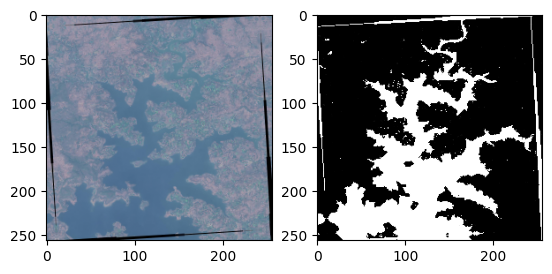

In [45]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


**This settings are customizable you could change it as you want. Encoder selection is important, your results will be according to it...**

In [46]:
DEVICE='cuda'

EPOCHS=45
BATCH_SIZE=32
LR=0.01

ratio=0.5 #Various ratios could perform better for visualization
sample_num=18

ENCODER='resnet50'
WEIGHTS='imagenet'

**We load the data with DataLoader...**

In [47]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)


**Here we determine the encoder and weights from the above variables in Unet.**

**The value of our loss function is the sum of the DiceLoss and BCEWithLogitsLoss.**

In [48]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [49]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [50]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

**We write the function to be used for training and eval so that things are simplified in the training cycle.**

In [51]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()


    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [52]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()

        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3)
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)


In [53]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
#torch.optim.Adam(model.parameters(),lr=LR)

**We use the adam optimizer and set up our training loop.**

**Here we want to save the best model and see our loss at every step...**

100%|██████████| 9/9 [00:06<00:00,  1.50it/s]


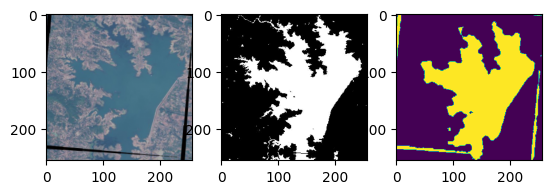

Epochs:1
Train_loss --> Dice: 0.3203072287142277 BCE: 0.4055302534252405 
Valid_loss --> Dice: 0.26379915740754867 BCE: 0.3197568605343501
Model Saved


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


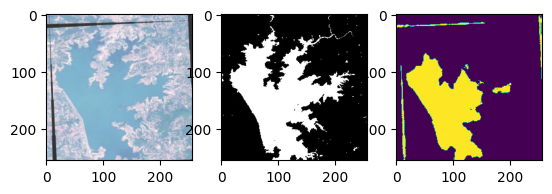

Epochs:2
Train_loss --> Dice: 0.232479178160429 BCE: 0.3045092225074768 
Valid_loss --> Dice: 0.26020129521687824 BCE: 0.3027185863918728
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


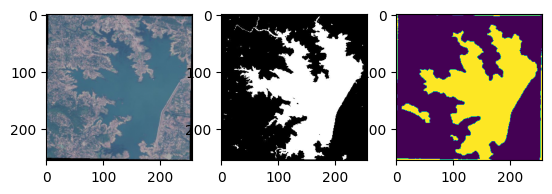

Epochs:3
Train_loss --> Dice: 0.20770224928855896 BCE: 0.27881638184189794 
Valid_loss --> Dice: 0.21828126907348633 BCE: 0.27905529737472534
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


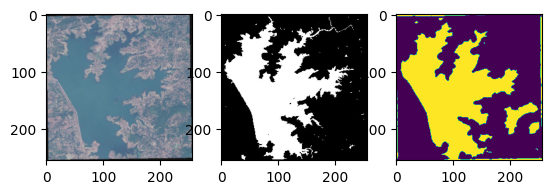

Epochs:4
Train_loss --> Dice: 0.19820246398448943 BCE: 0.26773025896400215 
Valid_loss --> Dice: 0.19681574238671196 BCE: 0.23957761956585777
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


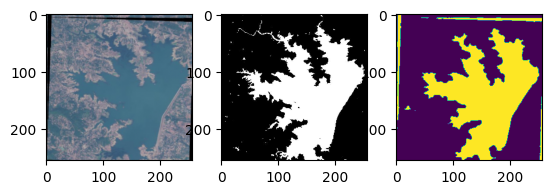

Epochs:5
Train_loss --> Dice: 0.1768508583307266 BCE: 0.23935547117143868 
Valid_loss --> Dice: 0.19544275601704916 BCE: 0.25197016033861375
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


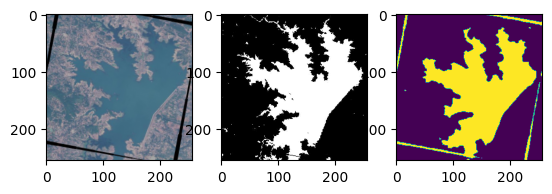

Epochs:6
Train_loss --> Dice: 0.16859667748212814 BCE: 0.23164323456585406 
Valid_loss --> Dice: 0.18511632415983412 BCE: 0.23116402328014374
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


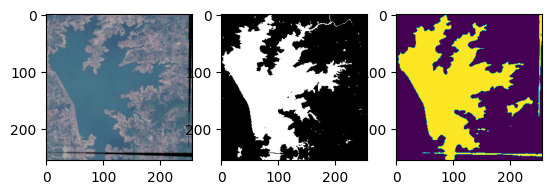

Epochs:7
Train_loss --> Dice: 0.1635991871356964 BCE: 0.22346923276782035 
Valid_loss --> Dice: 0.17280387216144139 BCE: 0.233085991607772
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


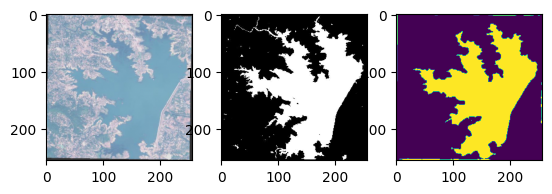

Epochs:8
Train_loss --> Dice: 0.15162770599126815 BCE: 0.21004743948578836 
Valid_loss --> Dice: 0.1711553004052904 BCE: 0.22477524975935617
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


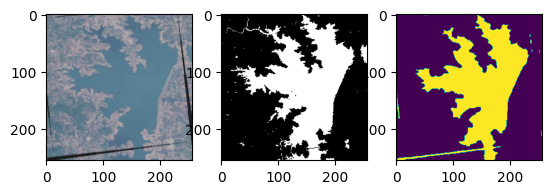

Epochs:9
Train_loss --> Dice: 0.14358751773834227 BCE: 0.19763914654031395 
Valid_loss --> Dice: 0.17543157604005602 BCE: 0.2362254477209515


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


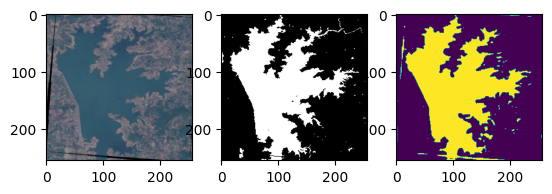

Epochs:10
Train_loss --> Dice: 0.14183930009603501 BCE: 0.19637959804385902 
Valid_loss --> Dice: 0.1694545414712694 BCE: 0.23650159107314217
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


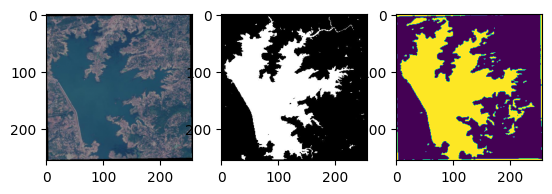

Epochs:11
Train_loss --> Dice: 0.13327685445547105 BCE: 0.184282710775733 
Valid_loss --> Dice: 0.1724261244138082 BCE: 0.23061368531650966
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


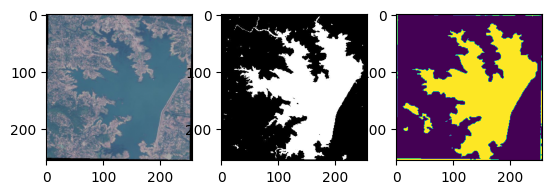

Epochs:12
Train_loss --> Dice: 0.12754647210240364 BCE: 0.1776497728191316 
Valid_loss --> Dice: 0.16635286145740086 BCE: 0.2580350753333833
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.89it/s]


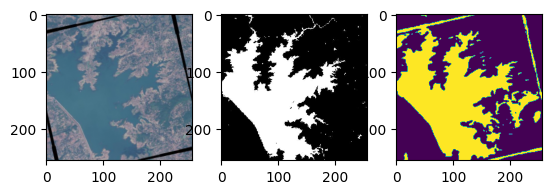

Epochs:13
Train_loss --> Dice: 0.12489181384444237 BCE: 0.17227758206427096 
Valid_loss --> Dice: 0.15903015269173515 BCE: 0.23472179306877983
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


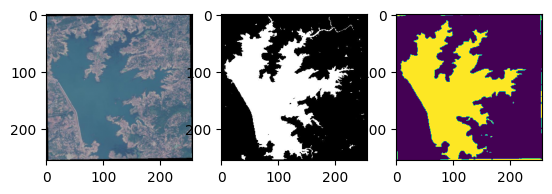

Epochs:14
Train_loss --> Dice: 0.11708689406514168 BCE: 0.16311008213087916 
Valid_loss --> Dice: 0.1515418158637153 BCE: 0.22787914176781973
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


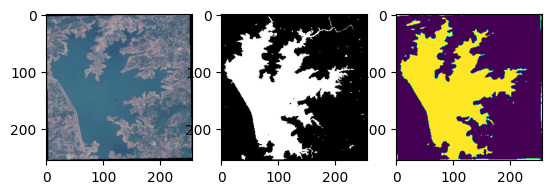

Epochs:15
Train_loss --> Dice: 0.11158096417784691 BCE: 0.15561626628041267 
Valid_loss --> Dice: 0.1466701759232415 BCE: 0.223184863726298
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.89it/s]


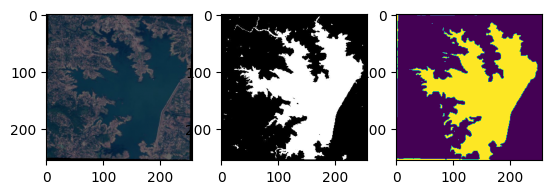

Epochs:16
Train_loss --> Dice: 0.1124703824520111 BCE: 0.15691364128142596 
Valid_loss --> Dice: 0.17124860816531712 BCE: 0.2636989868349499


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


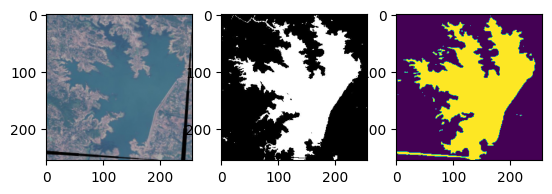

Epochs:17
Train_loss --> Dice: 0.11451795175671578 BCE: 0.16083874842152 
Valid_loss --> Dice: 0.15264785289764404 BCE: 0.23206138445271385


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


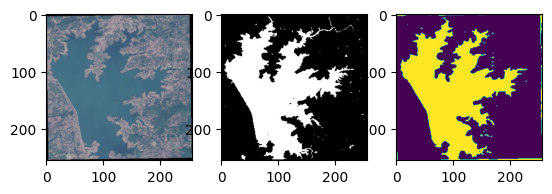

Epochs:18
Train_loss --> Dice: 0.11040446385741234 BCE: 0.15398701867088677 
Valid_loss --> Dice: 0.14596332444085014 BCE: 0.22954518927468193
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


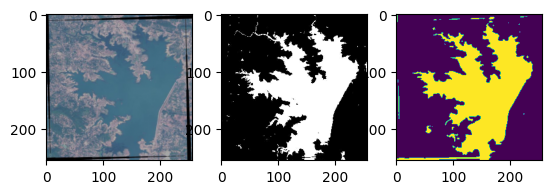

Epochs:19
Train_loss --> Dice: 0.10526264235377311 BCE: 0.14618883449584247 
Valid_loss --> Dice: 0.14749525652991402 BCE: 0.21114425857861838
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


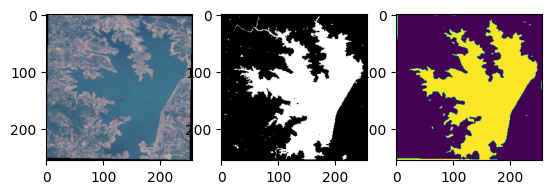

Epochs:20
Train_loss --> Dice: 0.10459676310420037 BCE: 0.14448103336617352 
Valid_loss --> Dice: 0.15348529815673828 BCE: 0.22603592773278555


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


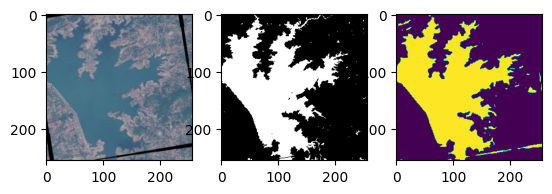

Epochs:21
Train_loss --> Dice: 0.10488132685422898 BCE: 0.14567269356921314 
Valid_loss --> Dice: 0.14143678214814928 BCE: 0.22154889669683245
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


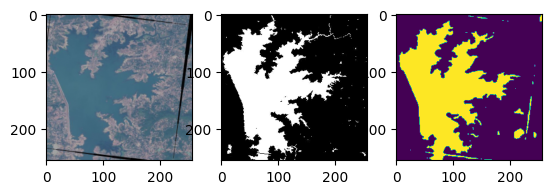

Epochs:22
Train_loss --> Dice: 0.09966792538762093 BCE: 0.1394045905210078 
Valid_loss --> Dice: 0.14230812920464408 BCE: 0.21285112533304426
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


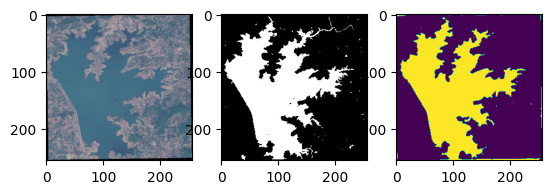

Epochs:23
Train_loss --> Dice: 0.09575254172086715 BCE: 0.13494289107620716 
Valid_loss --> Dice: 0.13829897509680855 BCE: 0.23058587974972194
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


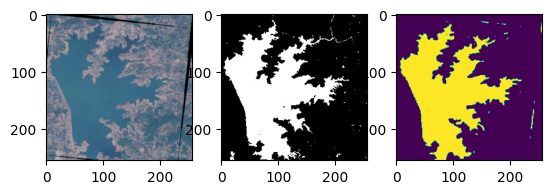

Epochs:24
Train_loss --> Dice: 0.09572298228740692 BCE: 0.13188159866258503 
Valid_loss --> Dice: 0.1482825411690606 BCE: 0.23832438389460245


100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


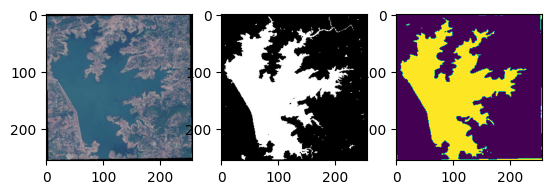

Epochs:25
Train_loss --> Dice: 0.09514426589012145 BCE: 0.13423214992508292 
Valid_loss --> Dice: 0.1376110381550259 BCE: 0.2210079613659117
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


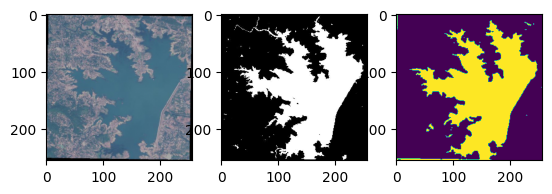

Epochs:26
Train_loss --> Dice: 0.09429905638098716 BCE: 0.13187575796619058 
Valid_loss --> Dice: 0.13550339804755318 BCE: 0.22047747009330326
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


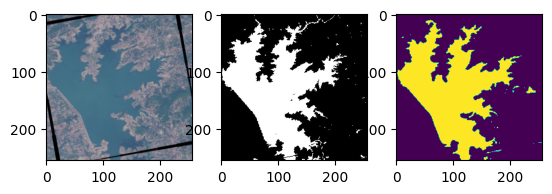

Epochs:27
Train_loss --> Dice: 0.09170226082205772 BCE: 0.1293269910849631 
Valid_loss --> Dice: 0.13874821530448067 BCE: 0.2318818320830663


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


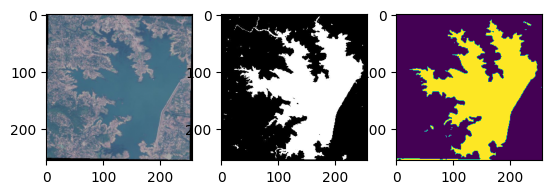

Epochs:28
Train_loss --> Dice: 0.0894222043454647 BCE: 0.1259570386260748 
Valid_loss --> Dice: 0.13948100805282593 BCE: 0.22721328172418806


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


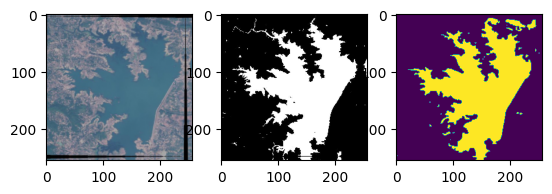

Epochs:29
Train_loss --> Dice: 0.0916126862168312 BCE: 0.12763924719765782 
Valid_loss --> Dice: 0.1397215591536628 BCE: 0.22295159763760036


100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


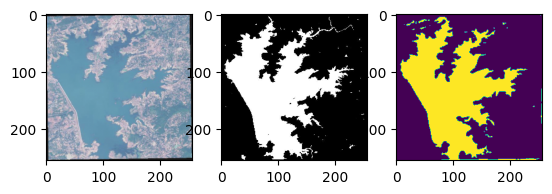

Epochs:30
Train_loss --> Dice: 0.08886711522936822 BCE: 0.1246547805145383 
Valid_loss --> Dice: 0.13650500112109715 BCE: 0.22832994494173262


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


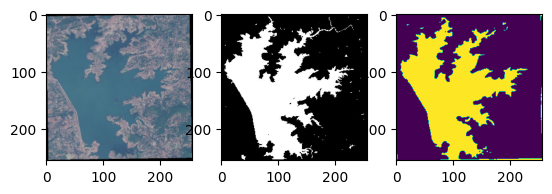

Epochs:31
Train_loss --> Dice: 0.08655562177300453 BCE: 0.12103512631729245 
Valid_loss --> Dice: 0.13427827093336317 BCE: 0.21926797926425934
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


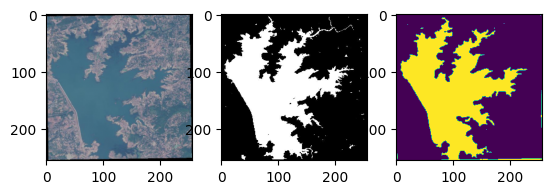

Epochs:32
Train_loss --> Dice: 0.08688428029417991 BCE: 0.12182501321658493 
Valid_loss --> Dice: 0.13681830962498984 BCE: 0.2139663514163759
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


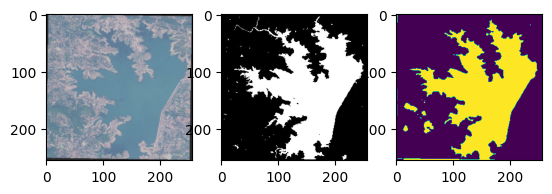

Epochs:33
Train_loss --> Dice: 0.08501369804143906 BCE: 0.11874739713966846 
Valid_loss --> Dice: 0.14026941193474662 BCE: 0.22918913265069327


100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


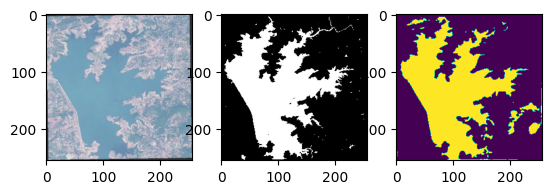

Epochs:34
Train_loss --> Dice: 0.08511154502630233 BCE: 0.11942110490053892 
Valid_loss --> Dice: 0.1338195867008633 BCE: 0.2277413308620453
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


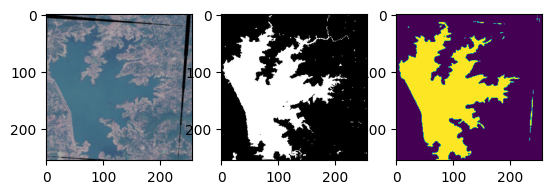

Epochs:35
Train_loss --> Dice: 0.08274173960089684 BCE: 0.11601734729483723 
Valid_loss --> Dice: 0.13467718495262992 BCE: 0.22827859554025862


100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


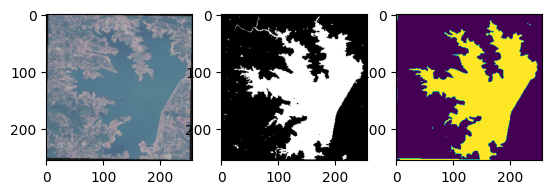

Epochs:36
Train_loss --> Dice: 0.08187639191746712 BCE: 0.11482584998011588 
Valid_loss --> Dice: 0.133513437377082 BCE: 0.2172410554356045
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


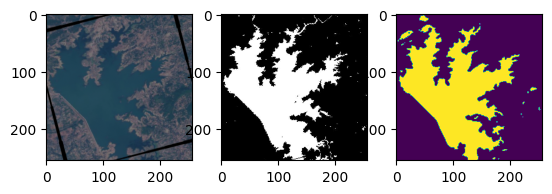

Epochs:37
Train_loss --> Dice: 0.08144217655062676 BCE: 0.1136680238880217 
Valid_loss --> Dice: 0.13797150717841256 BCE: 0.2474174698193868


100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


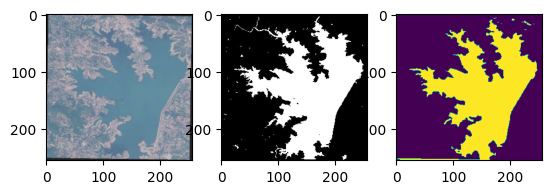

Epochs:38
Train_loss --> Dice: 0.08209858909249305 BCE: 0.11630374416708947 
Valid_loss --> Dice: 0.13161514202753702 BCE: 0.23059954742590585
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


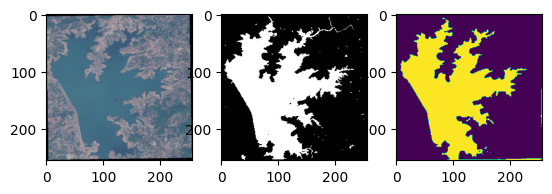

Epochs:39
Train_loss --> Dice: 0.08077105954289436 BCE: 0.11305494168773293 
Valid_loss --> Dice: 0.13532708750830758 BCE: 0.2356229540374544


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


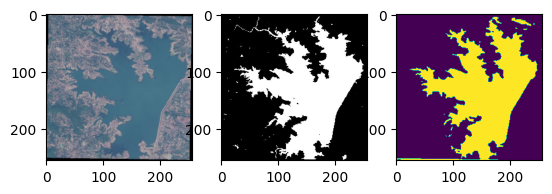

Epochs:40
Train_loss --> Dice: 0.0819142259657383 BCE: 0.11461166823282838 
Valid_loss --> Dice: 0.13895255989498562 BCE: 0.23917418056064182


100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


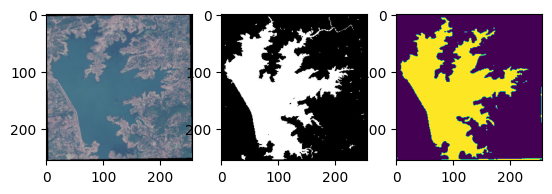

Epochs:41
Train_loss --> Dice: 0.0791148729622364 BCE: 0.11129054427146912 
Valid_loss --> Dice: 0.13216455115212333 BCE: 0.2228840341170629
Model Saved


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


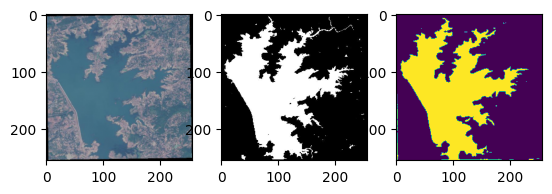

Epochs:42
Train_loss --> Dice: 0.07855692058801651 BCE: 0.1107842955738306 
Valid_loss --> Dice: 0.13468465540144178 BCE: 0.22779383427566952


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


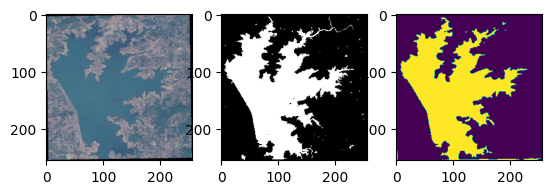

Epochs:43
Train_loss --> Dice: 0.07919704243540764 BCE: 0.11092974347993731 
Valid_loss --> Dice: 0.13651028606626722 BCE: 0.2348131752676434


100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


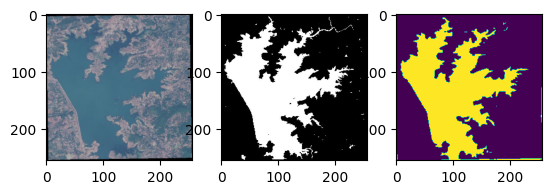

Epochs:44
Train_loss --> Dice: 0.07798114717006684 BCE: 0.1097896677441895 
Valid_loss --> Dice: 0.13586213853624132 BCE: 0.24498161673545837


100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


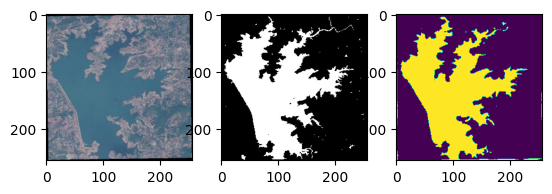

Epochs:45
Train_loss --> Dice: 0.07643058821558953 BCE: 0.1072237933985889 
Valid_loss --> Dice: 0.13223667939503989 BCE: 0.22313649290137821


In [54]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)

    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

In [65]:
def calculate_accuracy(model, data_loader, threshold=0.5):
    model.eval()
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE, dtype=torch.float32)
            masks = masks.to(DEVICE, dtype=torch.float32)

            logits = model(images)

            predicted_masks = torch.sigmoid(logits)
            predicted_masks = (predicted_masks > threshold).float()

            correct_pixels += (predicted_masks == masks).sum().item()
            total_pixels += masks.numel()

    accuracy = correct_pixels / total_pixels
    return accuracy

# Move the model to the same device as the input data
model.to(DEVICE)

# Usage
train_accuracy = calculate_accuracy(model, train_loader)
print(f'Training Accuracy: {train_accuracy}')

valid_accuracy = calculate_accuracy(model, valid_loader)
print(f'Validation Accuracy: {valid_accuracy}')


100%|██████████| 80/80 [00:33<00:00,  2.37it/s]


Training Accuracy: 0.8763116051520167


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

Validation Accuracy: 0.8520873488041393


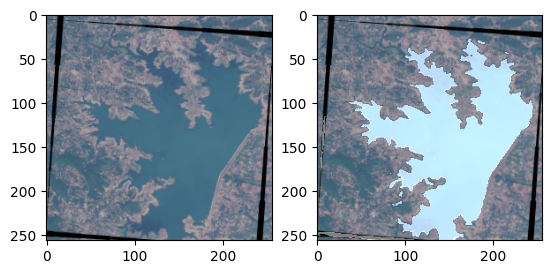

In [57]:
for i in range(1):
  image,mask = next(iter(valid_loader))
  image=image[sample_num]
  mask=mask[sample_num]

  logits_mask = model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > ratio)*1.0

  # Get numpy arrays
  image = image.cpu().numpy().transpose(1, 2, 0).astype(np.float32)
  mask = pred_mask.detach().cpu().numpy().squeeze().astype(np.float32)

# Make 3 channel mask
  mask = np.dstack([mask]*3)

# Merge mask and image
  merged = cv2.addWeighted(image, 1, mask, 0.5, 0)

# Display only original and merged
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(image)
axarr[1].imshow(merged)

plt.show()